In [ ]:
"""
Purpose: To improve the crossover function so it has more correct pairings made


The false crossover will just depend on downstream skeleton length
- need to fend off against the potential spines causing high degree nodes


"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")
sys.path.append("/meshAfterParty/meshAfterParty")

import datajoint_utils as du
from importlib import reload

INFO - 2021-04-24 04:24:12,184 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-04-24 04:24:12,186 - settings - Setting database.user to celiib
INFO - 2021-04-24 04:24:12,187 - settings - Setting database.password to newceliipass
INFO - 2021-04-24 04:24:12,224 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-04-24 04:24:12,225 - settings - Setting enable_python_native_blobs to True
INFO - 2021-04-24 04:24:12,241 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-04-24 04:24:12,707 - settings - Setting enable_python_native_blobs to True
INFO - 2021-04-24 04:24:12,736 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-04-24 04:24:12,737 - settings - Setting database.user to celiib
INFO - 2021-04-24 04:24:12,738 - settings - Setting database.password to newceliipass
INFO - 2021-04-24 04:24:12,739 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-04-24 04:24:12,740 - settings - Setting database.user to celiib
INFO - 2021-04-24 04:24:12,741 - settings - Setting database.password to newceliipass
INFO - 2021-04-24 04:24:12,743 - settings - Setting enable_python_native_blobs to True
INFO - 2021-04-24 04:24:13,232 - settings - Setting enable_python_native_blobs to True


In [3]:
#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-04-24 04:24:13,408 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-04-24 04:24:13,410 - settings - Setting database.user to celiib
INFO - 2021-04-24 04:24:13,411 - settings - Setting database.password to newceliipass
INFO - 2021-04-24 04:24:13,414 - settings - Setting enable_python_native_blobs to True
INFO - 2021-04-24 04:24:13,952 - settings - Setting enable_python_native_blobs to True


In [4]:
import validation_utils as vu
import neuron_visualizations as nviz
import neuron_utils as nru

# Downloading the Neuron

In [5]:
segment_id = 864691136194042326
minnie.Decomposition() & f"segment_id = {segment_id}"

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,index the index of the neuron object that resulted from that mesh (indexed starting at 0),multiplicity the number of somas found for this base segment,decomposition,n_vertices number of vertices,n_faces number of faces,n_not_processed_soma_containing_meshes the number of meshes with somas that were not processed,n_error_limbs the number of limbs that are touching multiple somas or 1 soma in multiple places,n_same_soma_multi_touching_limbs number of limbs that touch the same soma multiple times,n_multi_soma_touching_limbs number of limbs that touch multiple somas,n_somas number of soma meshes detected,n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,spine_density n_spines/ skeletal_length,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,run_time the amount of time to run (seconds)
864691136194042326,0,0.25,30.00,7,0,1,=BLOB=,543348,1100473,0,0,0,0,1,5,134,92,5711902.431454649,3489105.382868428,24117.997,87.607,87.607,543.496,482.187,1643,0.00028764496938046916,12.261194029850746,3062061.696,52,0.0005365665891534016,31.596,495451480854.54834,172336953.29870287,86740.18626896814,161803.232606894,9527913093.356699,5274.2019


In [6]:
restriction_dict = dict(segment_id=segment_id)
neuron_obj = (minnie.AutoProofreadValidationBorderNeurons() & restriction_dict).fetch1("decomposition")

Decompressing Neuron in minimal output mode...please wait


# Developing the high degree mechanism

In [12]:
limb_obj = neuron_obj[neuron_obj.axon_limb_name]

In [159]:
exactly_equal = False
crossover_coordinates = nru.high_degree_branching_coordinates_on_limb(limb_obj,min_degree_to_find=5,
                                                                         exactly_equal=exactly_equal,
                                                                         )
crossover_coordinates

array([[713252.41248611, 668208.00353725, 834130.63609803],
       [778454.85295756, 579963.51230716, 761154.47918387]])

In [165]:
winning_downstream,error_downstream = ed.high_degree_upstream_match(limb_obj,
                          coordinate = crossover_coordinates[1],
                        plot_intermediates = True,
                        plot_match_intermediates = True,
                          verbose=True)
print(winning_downstream,error_downstream)

For test node 229, sibling nodes were: [230]
overlap = []
With test node equal to the upstream node
upstream = 229, downstream_nodes = [234 235 236 237]
branches_at_coord = [229 234 235 236 237]
Returning No errors because not all branches were axons
None []


# Turning the Function Into a limb branch function that will work for axon

In [174]:
ed.high_degree_branch_errors_limb_branch_dict(neuron_obj)

{'L0': array([  7,   8,  10,  18,  46,  44,  58,  66,  79,  89,  72,  83,  93,
         81, 121, 131, 132, 133, 143, 103, 165, 171, 183,  39, 185, 160,
        194, 196, 203, 197])}

# Try Filtering Using the function

In [206]:
import proofreading_utils as pru
(filt_neuron,
 return_synapse_df_revised,
return_validation_df_revised) =  vu.filtered_neuron_score(neuron_obj = neuron_obj,   
                        filter_list = pru.v4_exc_filters(),
                        verbose = True,
                        plot_score=False)


--- Working on filter 0:
function = axon_on_dendrite_merges
function __name__ = filter_away_axon_on_dendrite_merges
function arguments = {'use_pre_existing_axon_labels': True}




Branches Requested to Remove (WITH disconnect effect)

 Working on visualization type: mesh



--- Working on filter 1:
function = high_degree_branching
function __name__ = filter_away_high_degree_branching
function arguments = {'offset': 1500, 'comparison_distance': 2000, 'worst_case_match_threshold': 65, 'width_diff_max': inf, 'match_threshold': 45, 'angle_buffer': 15, 'max_degree_to_resolve': 6, 'match_method': 'best_match'}


limb_branch_dict_to_cancel = {'L0': array([  7,   8,  10,  18,  46,  44,  58,  66,  79,  89,  72,  83,  93,
        81, 121, 131, 132, 133, 143, 103, 165, 171, 183,  39, 185, 160,
       194, 196, 203, 197])}


Branches Requested to Remove (WITH disconnect effect)

 Working on visualization type: mesh



--- Working on filter 2:
function = axon_webbing_t_merges
function __name__ = filter_away_webbing_t_merges
function arguments = {'child_width_maximum': 75, 'parent_width_maximum': 75, 'axon_only': True, 'error_if_web_is_none': True, 'web_size_threshold': 120, 'web_size_type': 'ray_trace_median', 'web_above_threshold': True}


limb_branch_dict_to_cancel = {}

--- Working on filter 3:
function = double_back_and_width_change
function __name__ = filter_away_large_double_back_or_width_changes
function arguments = {'perform_double_back_errors': True, 'skip_double_back_errors_for_axon': False, 'width_jump_threshold': 250, 'running_width_jump_method': True, 'double_back_axon_like_threshold': 145, 'double_back_threshold': 120, 'allow_axon_double_back_angle_with_top': 39, 'skeletal_length_to_skip': 4000, 'comparison_distance': 3000}


limb_branch_dict_to_cancel = {'L0': [18, 12, 14]}


Branches Requested to Remove (WITH disconnect effect)

 Working on visualization type: mesh



--- Working on filter 4:
function = axon_fork_divergence
function __name__ = filter_away_small_axon_fork_divergence
function arguments = {'divergence_threshold_mean': 165}


limb_branch_dict_to_cancel = {}



 ---- Total time for applying filter: 77.53833985328674 -----

--- Finished Part 1: Filtering Neuron -----
Apply the presyn non_error
For presyn: # valid synapses = 52, # error synapses  = 369, # error presyns = 25
For postsyn: # valid synapses = 3007, # error synapses  = 24, # error presyns = 0

--- Finished Part 2: Filtering Synapses -----
Synapsse Results:
Total Number of Synapses = 3452
n_valid_syn_ids_presyn = 52
n_errored_syn_ids_presyn = 369
n_valid_syn_ids_postsyn = 3007
n_errored_syn_ids_postsyn = 24

--- Finished Part 3: Generating Validation Dataframe -----


Segment Id = 864691136194042326
Postsyn counts:
TP:2982
TN:7
FP:25
FN:17
Presyn counts:
TP:40
TN:315
FP:12
FN:29


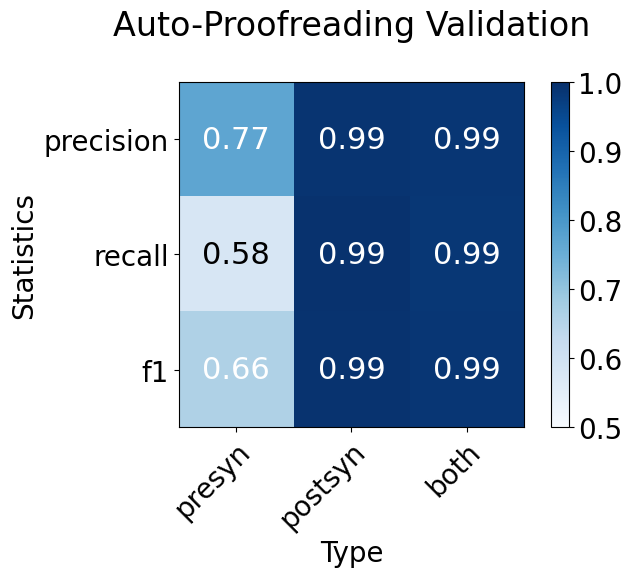

In [207]:
vu.synapse_validation_df_to_score_plot(return_validation_df_revised)

In [208]:
vu.plot_validation_synapses(segment_id,
                            validation_df = return_validation_df_revised,
                             synapse_dict = None,
                             synapses_type_to_plot = None,
                             synapses_type_to_not_plot = None,
                             verbose=False,
                             synapse_type = "presyn",
                             TP_color="yellow",
                            TN_color="aqua",
                            FP_color="black",
                            FN_color="orange",
                             synapse_scatter_size = 0.15,
                             
                             #for plotting the actual mesh parts to go along
                             
                             neuron_obj = filt_neuron,
                             plot_only_axon_skeleton = True,
                             error_mesh_color = "red",
                             valid_mesh_color = "green",
                             valid_skeleton_color = "black",
                             mesh_alpha = 0.3,)

Using the mesh from the neuron object


TP:yellow
TN:aqua
FP:black
FN:orange


In [204]:
crossover_coordinates = nru.high_degree_branching_coordinates_on_limb(limb_obj,min_degree_to_find=5,
                                                                             exactly_equal=True,
                                                                             )
crossover_coordinates

array([[713252.41248611, 668208.00353725, 834130.63609803],
       [778454.85295756, 579963.51230716, 761154.47918387]])

In [205]:
nviz.set_zoom(crossover_coordinates[0
                                   ])

In [ ]:
big_culprit_crossover = [713252.41248611, 668208.00353725, 834130.63609803]